In [586]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

In [569]:
df = yf.download('GC=F',interval='15m',period='60d')

/var/folders/_y/nftgz2w942b8mn9tb8_zpqk40000gn/T/ipykernel_21967/1407919987.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('GC=F',interval='15m',period='60d')
[*********************100%***********************]  1 of 1 completed


In [570]:
df

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Datetime,,,,,
2025-11-02 23:00:00+00:00,4006.199951,4006.500000,4001.800049,4001.899902,221
2025-11-02 23:15:00+00:00,4004.899902,4009.000000,3998.000000,4006.399902,1767
2025-11-02 23:30:00+00:00,3989.000000,4006.000000,3988.100098,4004.600098,1905
2025-11-02 23:45:00+00:00,3989.699951,3995.800049,3988.100098,3990.000000,1678
2025-11-03 00:00:00+00:00,3978.199951,3998.300049,3976.000000,3990.000000,4008
...,...,...,...,...,...
2026-01-13 18:15:00+00:00,4600.299805,4604.000000,4589.500000,4603.000000,16291
2026-01-13 18:30:00+00:00,4608.500000,4608.899902,4598.100098,4600.200195,5556


In [571]:
df.columns= df.columns.droplevel(1)

In [572]:
df.columns.name = None

In [573]:
df.reset_index(inplace=True)

In [574]:
df.rename(columns={"Datetime":'date', "Open":'open', "High":'high', "Low":'low', "Close":'close', "Adj Close":'adj_close', "Volume":'volume'}, inplace=True)

In [575]:
df['date']=pd.to_datetime(df['date']).dt.normalize()



In [576]:
df.head()

,date,close,high,low,open,volume
0,2025-11-02 00:00:00+00:00,4006.199951,4006.500000,4001.800049,4001.899902,221
1,2025-11-02 00:00:00+00:00,4004.899902,4009.000000,3998.000000,4006.399902,1767
2,2025-11-02 00:00:00+00:00,3989.000000,4006.000000,3988.100098,4004.600098,1905
3,2025-11-02 00:00:00+00:00,3989.699951,3995.800049,3988.100098,3990.000000,1678
4,2025-11-03 00:00:00+00:00,3978.199951,3998.300049,3976.000000,3990.000000,4008


In [577]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4342 entries, 0 to 4341
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    4342 non-null   datetime64[ns, UTC]
 1   close   4342 non-null   float64            
 2   high    4342 non-null   float64            
 3   low     4342 non-null   float64            
 4   open    4342 non-null   float64            
 5   volume  4342 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 203.7 KB


In [578]:
df.isna().sum()

date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

<Axes: >

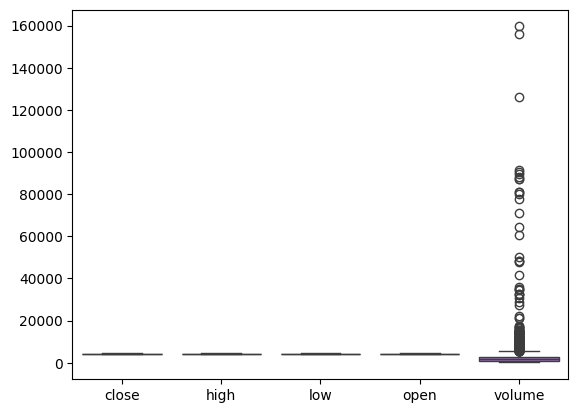

In [579]:
sns.boxplot(df)

In [580]:
df['volume'] = np.log1p(df['volume'])

In [581]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

In [582]:
import ta
import math
def RSI(DF,n=14):
    df = DF.copy()
    df['change']= df['close']-df['close'].shift(1)
    df['gain']= np.where(df['change']>0,df['change'],0)
    df["loss"]= np.where(df["change"]<0,-1*df["change"],0)
    df['avg_gain']= df['gain'].ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    df['avg_loss']= df['loss'].ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    df["rs"]= df['avg_gain']/df['avg_loss']
    df["rsi"]= 100- (100/(1+df["rs"]))
    return df["rsi"]

df['rsi']= RSI(df)

## Coding ATR using ta library
df['atr']= ta.volatility.AverageTrueRange(
    high=df['high'],
    low=df['low'],
    close=df['close'],
    window=14
).average_true_range()

##Coding MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_hist'] = macd.macd_diff()

## Moving Average
df['sma_20'] = df['close'].rolling(window=20).mean()
df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()

## Bollinger Band
bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
df['bb_high'] = bb.bollinger_hband()
df['bb_low'] = bb.bollinger_lband()

#Making target column for the direction
df['target']=(df['close'].shift(-1)> df['close']).astype(int)

In [583]:
df.head()

,date,close,high,low,open,volume,rsi,atr,macd,macd_signal,macd_hist,sma_20,ema_20,bb_high,bb_low,target
0,2025-11-02 00:00:00+00:00,4006.199951,4006.500000,4001.800049,4001.899902,5.402677,NaN,0.0,NaN,NaN,NaN,NaN,4006.199951,NaN,NaN,0
1,2025-11-02 00:00:00+00:00,4004.899902,4009.000000,3998.000000,4006.399902,7.477604,NaN,0.0,NaN,NaN,NaN,NaN,4006.076137,NaN,NaN,0
2,2025-11-02 00:00:00+00:00,3989.000000,4006.000000,3988.100098,4004.600098,7.552762,NaN,0.0,NaN,NaN,NaN,NaN,4004.449838,NaN,NaN,1
3,2025-11-02 00:00:00+00:00,3989.699951,3995.800049,3988.100098,3990.000000,7.425954,NaN,0.0,NaN,NaN,NaN,NaN,4003.045087,NaN,NaN,0
4,2025-11-03 00:00:00+00:00,3978.199951,3998.300049,3976.000000,3990.000000,8.296297,NaN,0.0,NaN,NaN,NaN,NaN,4000.678884,NaN,NaN,1


In [584]:
df.dropna(inplace=True)

In [585]:
df.isna().sum()

date           0
close          0
high           0
low            0
open           0
volume         0
rsi            0
atr            0
macd           0
macd_signal    0
macd_hist      0
sma_20         0
ema_20         0
bb_high        0
bb_low         0
target         0
dtype: int64

In [587]:
for lag in [1,2,3]:
    df[f"rsi_lag{lag}"]=df['rsi'].shift(lag)
    df[f"return_lag_{lag}"]=df['close'].pct_change(lag)

In [588]:
df

,date,close,high,low,open,volume,rsi,atr,macd,macd_signal,...,ema_20,bb_high,bb_low,target,rsi_lag1,return_lag_1,rsi_lag2,return_lag_2,rsi_lag3,return_lag_3
33,2025-11-03 00:00:00+00:00,4029.100098,4030.800049,4023.199951,4025.300049,7.005789,65.525839,8.756882,5.848213,5.620379,...,4020.163122,4031.340764,4010.599227,1,NaN,NaN,NaN,NaN,NaN,NaN
34,2025-11-03 00:00:00+00:00,4032.800049,4033.800049,4026.000000,4029.000000,7.207119,68.666611,8.688537,6.132482,5.722799,...,4021.366639,4032.668426,4011.401570,1,65.525839,0.000918,NaN,NaN,NaN,NaN
35,2025-11-03 00:00:00+00:00,4035.899902,4036.699951,4031.000000,4032.699951,7.427739,71.046585,8.475066,6.532595,5.884758,...,4022.750759,4034.748966,4011.461019,0,68.666611,0.000769,65.525839,0.001688,NaN,NaN
36,2025-11-03 00:00:00+00:00,4032.100098,4038.699951,4031.100098,4036.199951,7.620705,64.571973,8.412551,6.468510,6.001509,...,4023.641172,4035.823790,4011.816200,0,71.046585,-0.000942,68.666611,-0.000174,65.525839,0.000745
37,2025-11-03 00:00:00+00:00,4025.100098,4034.300049,4021.199951,4032.100098,7.821643,54.685060,8.747376,5.786181,5.958443,...,4023.780118,4035.772398,4012.737612,1,64.571973,-0.001736,71.046585,-0.002676,68.666611,-0.001909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,2026-01-13 00:00:00+00:00,4600.299805,4604.000000,4589.500000,4603.000000,9.698429,42.619203,11.524965,-0.723008,2.648185,...,4612.504959,4640.717266,4598.322724,1,44.018291,-0.000587,41.370804,0.000283,48.757644,-0.002710
4338,2026-01-13 00:00:00+00:00,4608.500000,4608.899902,4598.100098,4600.200195,8.622814,48.022299,11.473168,-0.895499,1.939449,...,4612.123534,4640.069842,4597.160139,0,42.619203,0.001783,44.018291,0.001195,41.370804,0.002066
4339,2026-01-13 00:00:00+00:00,4602.299805,4610.200195,4602.000000,4608.600098,7.595890,44.602496,11.239384,-1.515038,1.248551,...,4611.187941,4640.347736,4595.162225,1,48.022299,-0.001345,42.619203,0.000435,44.018291,-0.000152
4340,2026-01-13 00:00:00+00:00,4603.700195,4604.000000,4592.399902,4602.600098,8.130942,45.545728,11.265150,-1.871455,0.624550,...,4610.474822,4639.597297,4593.612664,0,44.602496,0.000304,48.022299,-0.001042,42.619203,0.000739


In [589]:
df.dropna(inplace=True)

In [590]:
df

,date,close,high,low,open,volume,rsi,atr,macd,macd_signal,...,ema_20,bb_high,bb_low,target,rsi_lag1,return_lag_1,rsi_lag2,return_lag_2,rsi_lag3,return_lag_3
36,2025-11-03 00:00:00+00:00,4032.100098,4038.699951,4031.100098,4036.199951,7.620705,64.571973,8.412551,6.468510,6.001509,...,4023.641172,4035.823790,4011.816200,0,71.046585,-0.000942,68.666611,-0.000174,65.525839,0.000745
37,2025-11-03 00:00:00+00:00,4025.100098,4034.300049,4021.199951,4032.100098,7.821643,54.685060,8.747376,5.786181,5.958443,...,4023.780118,4035.772398,4012.737612,1,64.571973,-0.001736,71.046585,-0.002676,68.666611,-0.001909
38,2025-11-03 00:00:00+00:00,4027.500000,4028.500000,4022.699951,4025.399902,7.670429,57.109746,8.536852,5.377099,5.842174,...,4024.134392,4036.077154,4013.092865,1,54.685060,0.000596,64.571973,-0.001141,71.046585,-0.002081
39,2025-11-03 00:00:00+00:00,4029.899902,4031.199951,4023.500000,4027.300049,7.527794,59.446571,8.477074,5.186761,5.711092,...,4024.683488,4036.626257,4013.403748,1,57.109746,0.000596,54.685060,0.001192,64.571973,-0.000546
40,2025-11-03 00:00:00+00:00,4032.800049,4036.899902,4027.000000,4030.199951,7.766841,62.131639,8.578704,5.209878,5.610849,...,4025.456494,4037.503205,4013.796795,0,59.446571,0.000720,57.109746,0.001316,54.685060,0.001913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,2026-01-13 00:00:00+00:00,4600.299805,4604.000000,4589.500000,4603.000000,9.698429,42.619203,11.524965,-0.723008,2.648185,...,4612.504959,4640.717266,4598.322724,1,44.018291,-0.000587,41.370804,0.000283,48.757644,-0.002710
4338,2026-01-13 00:00:00+00:00,4608.500000,4608.899902,4598.100098,4600.200195,8.622814,48.022299,11.473168,-0.895499,1.939449,...,4612.123534,4640.069842,4597.160139,0,42.619203,0.001783,44.018291,0.001195,41.370804,0.002066
4339,2026-01-13 00:00:00+00:00,4602.299805,4610.200195,4602.000000,4608.600098,7.595890,44.602496,11.239384,-1.515038,1.248551,...,4611.187941,4640.347736,4595.162225,1,48.022299,-0.001345,42.619203,0.000435,44.018291,-0.000152
4340,2026-01-13 00:00:00+00:00,4603.700195,4604.000000,4592.399902,4602.600098,8.130942,45.545728,11.265150,-1.871455,0.624550,...,4610.474822,4639.597297,4593.612664,0,44.602496,0.000304,48.022299,-0.001042,42.619203,0.000739


In [591]:
features = [
    'rsi','atr','macd_hist', 'ema_20',
    'sma_20',
    'bb_high',
    'bb_low',
    'volume',
    'return_lag_1','return_lag_2','return_lag_2',
    'rsi_lag1','rsi_lag2','rsi_lag3'
]

In [592]:
X = df[features]
y= df['target']

In [593]:
X

,rsi,atr,macd_hist,ema_20,sma_20,bb_high,bb_low,volume,return_lag_1,return_lag_2,return_lag_2,rsi_lag1,rsi_lag2,rsi_lag3
36,64.571973,8.412551,0.467001,4023.641172,4023.819995,4035.823790,4011.816200,7.620705,-0.000942,-0.000174,-0.000174,71.046585,68.666611,65.525839
37,54.685060,8.747376,-0.172262,4023.780118,4024.255005,4035.772398,4012.737612,7.821643,-0.001736,-0.002676,-0.002676,64.571973,71.046585,68.666611
38,57.109746,8.536852,-0.465075,4024.134392,4024.585010,4036.077154,4013.092865,7.670429,0.000596,-0.001141,-0.001141,54.685060,64.571973,71.046585
39,59.446571,8.477074,-0.524331,4024.683488,4025.015002,4036.626257,4013.403748,7.527794,0.000596,0.001192,0.001192,57.109746,54.685060,64.571973
40,62.131639,8.578704,-0.400971,4025.456494,4025.650000,4037.503205,4013.796795,7.766841,0.000720,0.001316,0.001316,59.446571,57.109746,54.685060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4337,42.619203,11.524965,-3.371194,4612.504959,4619.519995,4640.717266,4598.322724,9.698429,-0.000587,0.000283,0.000283,44.018291,41.370804,48.757644
4338,48.022299,11.473168,-2.834948,4612.123534,4618.614990,4640.069842,4597.160139,8.622814,0.001783,0.001195,0.001195,42.619203,44.018291,41.370804
4339,44.602496,11.239384,-2.763590,4611.187941,4617.754980,4640.347736,4595.162225,7.595890,-0.001345,0.000435,0.000435,48.022299,42.619203,44.018291
4340,45.545728,11.265150,-2.496005,4610.474822,4616.604980,4639.597297,4593.612664,8.130942,0.000304,-0.001042,-0.001042,44.602496,48.022299,42.619203


In [546]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
tscv= TimeSeriesSplit(n_splits=5)

for fold,(train_idx,test_idx) in enumerate(tscv.split(X),1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ##Scaling the data
    robust = RobustScaler()
    X_train = robust.fit_transform(X_train)
    X_test = robust.transform(X_test)

    ##Model training
    model = RandomForestClassifier(n_estimators=300,max_depth=6,random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    ##printing the confusion metrics and accuracy score
    print(f'\nFold {fold}')
    print("Confusion report:",confusion_matrix(y_test,y_pred))
    print("Accuracy score:",accuracy_score(y_test,y_pred))
    print("Classfication report:",classification_report(y_test,y_pred))





Fold 1
Confusion report: [[104 244]
 [123 246]]
Accuracy score: 0.4881450488145049
Classfication report:               precision    recall  f1-score   support

           0       0.46      0.30      0.36       348
           1       0.50      0.67      0.57       369

    accuracy                           0.49       717
   macro avg       0.48      0.48      0.47       717
weighted avg       0.48      0.49      0.47       717


Fold 2
Confusion report: [[254  87]
 [262 114]]
Accuracy score: 0.5132496513249651
Classfication report:               precision    recall  f1-score   support

           0       0.49      0.74      0.59       341
           1       0.57      0.30      0.40       376

    accuracy                           0.51       717
   macro avg       0.53      0.52      0.49       717
weighted avg       0.53      0.51      0.49       717


Fold 3
Confusion report: [[181 162]
 [203 171]]
Accuracy score: 0.4909344490934449
Classfication report:               precision    r

In [547]:
X_train

array([[ 0.79950467, -0.04184653,  0.21500084, ...,  1.20363139,
         1.05412409,  0.85702352],
       [ 0.18137196,  0.03464202, -0.09545831, ...,  0.79904852,
         1.20276068,  1.05302375],
       [ 0.33296404, -0.01345068, -0.23766357, ...,  0.18123925,
         0.7984016 ,  1.20154634],
       ...,
       [-0.15065746,  0.60808849, -0.7046571 , ..., -0.35730425,
        -0.27116575, -0.26408509],
       [-0.28860515,  0.53861541, -0.69340597, ..., -0.15061643,
        -0.35731157, -0.27124965],
       [-0.05002569,  0.46431266, -0.48446341, ..., -0.28849193,
        -0.15073807, -0.35732939]], shape=(3589, 14))

In [548]:
split = int(len(X)*0.7)

X_train,X_test = X.iloc[:split],X.iloc[split:]
y_train,y_test = y.iloc[:split],y.iloc[split:]

In [549]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [550]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300,
    max_depth=6,
    random_state=42)
model.fit(X_train,y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [551]:
y_pred = model.predict(X_test)

In [654]:
proba = model.predict_proba(X_test)

In [661]:
proba

array([[0.47848125, 0.52151875],
       [0.52244173, 0.47755827],
       [0.52883122, 0.47116878],
       ...,
       [0.54885285, 0.45114715],
       [0.60079752, 0.39920248],
       [0.52766216, 0.47233784]], shape=(1292, 2))

In [ ]:
df_test= df.iloc[split:].copy()
df_test['signal'] = 0

df_test.loc[proba[:,1] > 0.70, 'signal'] = 1    
df_test.loc[proba[:,1] < 0.55, 'signal'] = -1   

df_test['signal'] = df_test['signal'].shift(1)


In [739]:
df_test['return']=df_test['close'].pct_change()

In [795]:
df_test["entry_price"]= df_test['close'].shift(1)

In [796]:
df_test['strategy_return']=0.0

In [ ]:
risk_per_trade = 0.01
RR = 1.5          
reward_per_trade = risk_per_trade * RR

sl_mult = 1.0        
tp_mult = RR          
max_hold = 10         
df_test['strategy_return'] = 0.0
i= 1

while i<len(df_test):
    signal = df_test.iloc[i]['signal']
    atr    = df_test.iloc[i]['atr']
    entry  = df_test.iloc[i]['entry_price']
    if signal == 0 or pd.isna(entry) or atr <= 0:
        i += 1
        continue
    #Defining SL/TP
    if signal == 1:  # LONG
        sl = entry - sl_mult * atr
        tp = entry + tp_mult * atr
    else:            # SHORT
        sl = entry + sl_mult * atr
        tp = entry - tp_mult * atr

    exit_found = False
    
    for j in range(i, min(i + max_hold, len(df_test))):

        high = df_test.iloc[j]['high']
        low  = df_test.iloc[j]['low']

        #LONG
        if signal == 1:
            if low <= sl:
                df_test.iloc[j, df_test.columns.get_loc('strategy_return')] = -risk_per_trade
                exit_found = True
                i = j + 1
                break
            elif high >= tp:
                df_test.iloc[j, df_test.columns.get_loc('strategy_return')] = reward_per_trade
                exit_found = True
                i = j + 1
                break

        #SHORT
        else:
            if high >= sl:
                df_test.iloc[j, df_test.columns.get_loc('strategy_return')] = -risk_per_trade
                exit_found = True
                i = j + 1
                break
            elif low <= tp:
                df_test.iloc[j, df_test.columns.get_loc('strategy_return')] = reward_per_trade
                exit_found = True
                i = j + 1
                break

    # Time exit
    if not exit_found:
        df_test.iloc[j, df_test.columns.get_loc('strategy_return')] = 0
        i = j + 1


In [842]:
df_test['equity'] = (1 + df_test['strategy_return']).cumprod()

In [843]:
max_drawdown = (
    df_test['equity'] / df_test['equity'].cummax() - 1
).min()

total_return = df_test['equity'].iloc[-1] - 1

print("ATR Strategy Return:", round(total_return*100, 1))
print("Max Drawdown:", round(max_drawdown*100, 2), "%")


ATR Strategy Return: -14.3
Max Drawdown: -22.1 %


In [844]:
print("Wins:", (df_test['strategy_return'] > 0).sum())
print("Losses:", (df_test['strategy_return'] < 0).sum())
print("Zero:", (df_test['strategy_return'] == 0).sum())
print("Unique returns:", df_test['strategy_return'].unique())


Wins: 101
Losses: 165
Zero: 1026
Unique returns: [ 0.    -0.01   0.015]


<Axes: title={'center': 'Equity Curve (ML + ATR Strategy)'}>

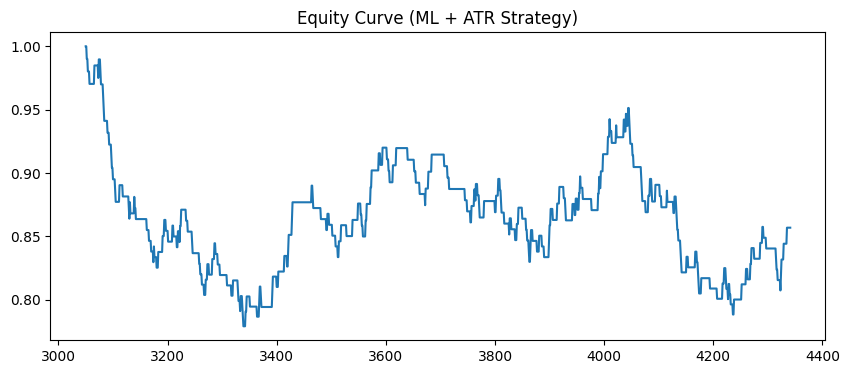

In [845]:
import matplotlib.pyplot as plt

df_test['equity'] = (1 + df_test['strategy_return']).cumprod()

df_test['equity'].plot(
    figsize=(10,4),
    title="Equity Curve (ML + ATR Strategy)"
)

In [849]:

sharpe = (
    df_test['strategy_return'].mean() /
    df_test['strategy_return'].std()
) * np.sqrt(252)
print("Sharpe:",sharpe)


Sharpe: -0.3009755899848524
